In [1]:
import pandas as pd

df = pd.read_json("penguin_party_mix_dataset.jsonl", lines=True)
# Giữ lại các lượt đi của người thắng
df_win = df[df['turn'] == df['winner']]

print(len(df))
print(len(df_win))
print(df_win.head())
print(df_win.label.value_counts())

3696336
1883712
   turn board                                               hand  pos   color  \
0     0    {}  [yellow, green, blue, purple, red, green, red,...  1-7     red   
1     0    {}  [yellow, green, blue, purple, red, green, red,...  1-7  purple   
2     0    {}  [yellow, green, blue, purple, red, green, red,...  1-7    blue   
3     0    {}  [yellow, green, blue, purple, red, green, red,...  1-7   green   
4     0    {}  [yellow, green, blue, purple, red, green, red,...  1-7  yellow   

   label  winner     bot  
0      0       0  greedy  
1      0       0  greedy  
2      0       0  greedy  
3      0       0  greedy  
4      1       0  greedy  
label
0    1665807
1     217905
Name: count, dtype: int64


In [2]:
import numpy as np

colors = ["green", "red", "blue", "yellow", "purple"]

def encode_board(board):
    cnt = [0]*5
    for v in board.values():
        if v in colors:
            cnt[colors.index(v)] += 1
    return cnt

def encode_hand(hand):
    return [hand.count(c) for c in colors]

def encode_sample(row):
    bvec = encode_board(row['board'])
    hvec = encode_hand(row['hand'])
    row_idx, col_idx = [int(x) for x in row['pos'].split('-')]
    color_oh = [0]*5
    color_oh[colors.index(row['color'])] = 1
    return hvec + bvec + [row_idx, col_idx] + color_oh

X = np.array([encode_sample(r) for i, r in df_win.iterrows()])
y = df_win['label'].values
print(X.shape, y.shape)

(1883712, 17) (1883712,)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
print("Train label distribution:", np.bincount(y_train))
print("Test label distribution: ", np.bincount(y_test))

Train label distribution: [1499226  196114]
Test label distribution:  [166581  21791]


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tqdm import tqdm

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=1)
}

fitted_models = {}
scores_log = {}

for name, model in tqdm(models.items()):
    print(f"\nTraining model: {name}")
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f"Finished {name}")

  0%|          | 0/4 [00:00<?, ?it/s]


Training model: RandomForest


 25%|██▌       | 1/4 [03:00<09:02, 180.69s/it]

Finished RandomForest

Training model: LogisticRegression


 50%|█████     | 2/4 [03:04<02:33, 76.72s/it] 

Finished LogisticRegression

Training model: DecisionTree


 75%|███████▌  | 3/4 [03:13<00:45, 45.58s/it]

Finished DecisionTree

Training model: XGBoost


c:\Users\Admin\anaconda3\envs\sad\lib\site-packages\xgboost\training.py:183: UserWarning: [10:56:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
100%|██████████| 4/4 [03:15<00:00, 48.78s/it]

Finished XGBoost


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

metric_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
scores_log = {name: {} for name in models.keys()}

for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    scores_log[name]["Accuracy"] = acc
    scores_log[name]["Precision"] = prec
    scores_log[name]["Recall"] = rec
    scores_log[name]["F1"] = f1
    scores_log[name]["AUC"] = auc

    print(f"\n{name}:\n  Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  AUC: {auc:.4f}")
    print(f"  Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


RandomForest:
  Accuracy: 0.8812  Precision: 0.4833  Recall: 0.3874  F1: 0.4300  AUC: 0.8510
  Confusion Matrix:
[[157557   9024]
 [ 13350   8441]]

LogisticRegression:
  Accuracy: 0.6784  Precision: 0.1936  Recall: 0.5624  F1: 0.2880  AUC: 0.6825
  Confusion Matrix:
[[115535  51046]
 [  9536  12255]]

DecisionTree:
  Accuracy: 0.8441  Precision: 0.3652  Recall: 0.4703  F1: 0.4111  AUC: 0.6878
  Confusion Matrix:
[[148763  17818]
 [ 11542  10249]]

XGBoost:
  Accuracy: 0.9017  Precision: 0.7026  Recall: 0.2611  F1: 0.3807  AUC: 0.8719
  Confusion Matrix:
[[164173   2408]
 [ 16102   5689]]


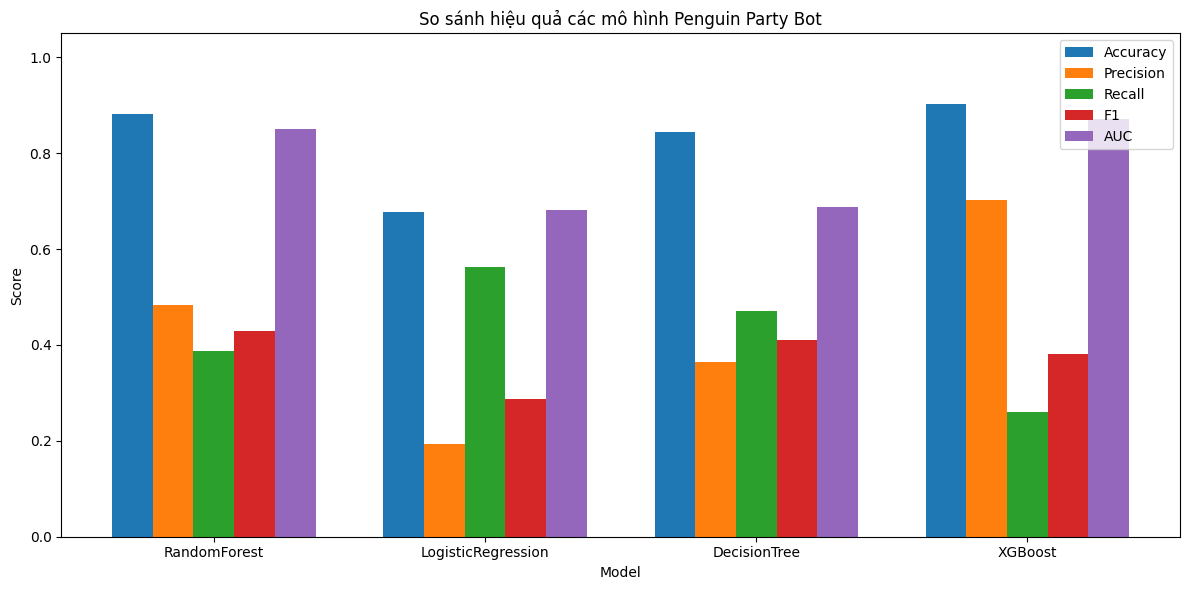

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert scores_log thành DataFrame để dễ plot
df_score = pd.DataFrame(scores_log).T[metric_names]

# Vẽ cột nhóm cho từng metric
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(df_score))

for i, metric in enumerate(metric_names):
    plt.bar(index + i*bar_width, df_score[metric], bar_width, label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('So sánh hiệu quả các mô hình Penguin Party Bot')
plt.xticks(index + 2*bar_width, df_score.index)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
import joblib

for name, model in fitted_models.items():
    joblib.dump(model, f"new_penguinparty_{name}.pkl")
    print(f"Đã lưu model: new_penguinparty_{name}.pkl")

Đã lưu model: new_penguinparty_RandomForest.pkl
Đã lưu model: new_penguinparty_LogisticRegression.pkl
Đã lưu model: new_penguinparty_DecisionTree.pkl
Đã lưu model: new_penguinparty_XGBoost.pkl


# Metrics Đánh Giá Hiệu Quả Training Penguin Party Bot

## Tổng quan bài toán

- **Bài toán:** Dự đoán nước đi tốt nhất cho bot trong trò chơi Penguin Party, dưới dạng classification (label = 1 nếu là nước đi thực tế bot chọn, 0 nếu là các nước đi hợp lệ khác).
- **Mục tiêu:** Model cho điểm (score/xác suất) với từng nước đi hợp lệ, tối ưu khả năng chọn đúng nước đi mà con người (hoặc random policy ban đầu) đã chọn, từ đó dần tiến đến lựa chọn nước đi tối ưu (tăng xác suất thắng).
- **Dữ liệu:** Mỗi sample là một nước đi hợp lệ tại một lượt chơi cụ thể.

---

## Ý nghĩa các chỉ số đánh giá (metrics)

### 1. **Accuracy** (Độ chính xác)
- **Định nghĩa:**  
  Tỉ lệ số dự đoán đúng trên tổng số sample kiểm tra.
- **Công thức:**  
  $$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$
- **Ý nghĩa trong bài toán:**  
  - Accuracy cao nghĩa là model thường đoán đúng (chọn nước đi thực sự) trong toàn bộ các lựa chọn.  
  - Tuy nhiên, vì số label = 1 rất nhỏ so với label = 0 (data mất cân bằng), nên accuracy dễ bị "ảo" (model chỉ đoán 0 cũng đã đạt ~99%).

---

### 2. **Precision** (Độ chính xác dương tính)
- **Định nghĩa:**  
  Tỉ lệ số nước đi mà model dự đoán là đúng (label = 1), thực sự là đúng.
- **Công thức:**  
  $$ Precision = \frac{TP}{TP + FP} $$
- **Ý nghĩa:**  
  - Precision cao nghĩa là mỗi khi model "chọn" một nước đi là tốt nhất, thì xác suất cao nó đúng thật sự.
  - Tránh việc model đoán bừa nhiều 1 (nước đi thật), gây ra nhiều lỗi sai.

---

### 3. **Recall** (Độ phủ dương tính / Nhạy cảm)
- **Định nghĩa:**  
  Tỉ lệ số nước đi thật sự là đúng (label = 1) mà model dự đoán đúng.
- **Công thức:**  
  $$ Recall = \frac{TP}{TP + FN} $$
- **Ý nghĩa:**  
  - Recall cao nghĩa là model không bỏ sót các nước đi đúng thật sự.
  - Phù hợp cho bài toán mà việc bỏ lỡ nước đi "đúng" là nghiêm trọng.

---

### 4. **F1-Score**
- **Định nghĩa:**  
  Trung bình điều hòa giữa Precision và Recall.
- **Công thức:**  
  $$ F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} $$
- **Ý nghĩa:**  
  - F1-score cân bằng giữa Precision và Recall, phù hợp cho bài toán mất cân bằng nhãn như hiện tại.
  - F1 cao nghĩa là model vừa không đoán bừa, vừa không bỏ sót.

---

### 5. **ROC-AUC** (Area Under the Curve of Receiver Operating Characteristic)
- **Định nghĩa:**  
  Đo lường khả năng phân biệt giữa 2 lớp (label 0 và 1) của model dựa trên xác suất (score) mà model dự đoán.
- **Giá trị:**  
  - 1.0: model hoàn hảo  
  - 0.5: model đoán ngẫu nhiên
- **Ý nghĩa:**  
  - AUC cao chứng tỏ model phân biệt tốt giữa nước đi thực sự và các nước hợp lệ khác.
  - Đặc biệt hữu ích khi data mất cân bằng.

---

## Ý nghĩa thực tế của các chỉ số trong Penguin Party

- **Accuracy**: Thường rất cao (do sample mất cân bằng) nhưng chưa hẳn thể hiện khả năng "chọn đúng nước đi".
- **Precision, Recall, F1**: Làm rõ khả năng model nhận diện chính xác nước đi thật sự (tránh đoán bừa hoặc bỏ sót).
- **ROC-AUC**: Giúp đo mức phân biệt khi xét theo xác suất, không phụ thuộc ngưỡng cứng.

**=> Khi so sánh các mô hình, nên ưu tiên F1 và ROC-AUC!**

---

## Thực hành

- Khi đánh giá trên tập test, luôn in đủ các chỉ số trên, không chỉ accuracy.
- Vẽ biểu đồ so sánh để chọn model phù hợp nhất (trực quan F1, AUC cao là tốt).
- Sau này khi dùng model để "chấm điểm" các nước đi hợp lệ trong thực chiến, lấy xác suất (proba) cao nhất để chọn nước đi tối ưu.